---
title: "Data Manipulation with dplyrXdf"
author: "Microsoft Data Science Team"
date: "June 6, 2016"
output:
  ioslides_presentation:
    logo: images/clark-logo.png
    smaller: yes
    widescreen: yes
  html_document:
    toc: yes
    keep_md: true
---


# Introduction

## Overview 
### Plan

At the end of this session, you will have learned how to:

* Take advantage of the verbs and syntax you learned from the `dplyr` module to manipulate `RxXdfData` data objects
* Summarize your `RxXdfData` objects quickly and easily
* Create custom functions and use them for mutations and summarizations
* Understand where and when to use the `dplyrXdf` package and when to use functions from the `RevoScaleR` package

## Why dplyrXdf?
### Simplify Your Analysis Pipeline

* The `RevoScaleR` package enables R users to manipulate data that is larger than memory
* It introduces a new data type, called an `xdf` (short for eXternal Data Frame), which are highly efficient out-of-memory objects
* However, many of the `RevoScaleR` functions have a dramatically different syntax from base R functions
* The `dplyr` package has becme exceptionally popular, due to its appealing syntax, and since it's extensible, we have created a new package called `dplyrXdf` that exposes most of the `dplyr` functionality to `xdf` objects
* Many data analysis pipelines require creating many intermediate datasets, which are only needed for their role in deriving a final dataset, but have no/little use on their own
* The `dplyrXdf` abstracts this task of file management, so that you can focus on the data itself, rather than the management of intermediate files
* Unlike `dplyr`, or other base R packages, `dplyrXdf` allows you to work with data residing _outside_ of memory, and therefore scales to datasets of arbitrary size


## Requirements 
### What You'll Need

* I expect that you have already covered the `dplyr` training
* Understand the *XDF* data type and how to import data to *XDF*
* If you're working on a different computer than your trianer: have (`devtools`)[github.com/hadley/devtools] (and if on a Windows machine, [Rtools](https://cran.r-project.org/bin/windows/Rtools/))

## Installing dplyrXdf

* The `dplyrXdf` package is not yet on CRAN
* You have to download it from [github](https://github.com/RevolutionAnalytics/dplyrXdf/)
  - if you're on a windows machine, install [Rtools](https://cran.r-project.org/bin/windows/Rtools/) as well
  - the `devtools` package provides a very handy function, `install_github`, for installing R packages saved in github repositories

## Create XDF from taxi data

### Create a local directory to save XDF

In [1]:
user.name <- "alizaidi"
mydir <- sprintf('C:/Data/%s/', user.name)
dir.create(mydir)
setwd(mydir)

Warning message:
In dir.create(mydir): 'C:\Data\alizaidi' already exists

In [17]:
file.copy("C:/Data/NYC_Taxi/yellow_tripdata_2015.xdf",
         "yellow_tripdata_2015.xdf", overwrite = TRUE)

[1] TRUE

In [2]:
library(dplyrXdf)
taxi_xdf <- RxXdfData("yellow_tripdata_2015.xdf")

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [3]:
taxi_xdf %>% head

,VendorID,passenger_count,trip_distance,RateCodeID,store_and_fwd_flag,payment_type,fare_amount,tip_amount,tolls_amount,pickup_hour,pickup_dow,dropoff_hour,dropoff_dow,pickup_nhood,dropoff_nhood,kSplits
1,2,1,1.59,1,N,1,12,3.25,0,6-10,Thu,6-10,Thu,Garment District,Murray Hill,D
2,1,1,3.3,1,N,1,14.5,2,0,6-10,Sat,6-10,Sat,Soho,Clinton,G
3,1,1,1.8,1,N,2,9.5,0,0,6-10,Sat,6-10,Sat,Morningside Heights,Hamilton Heights,A
4,1,1,0.5,1,N,2,3.5,0,0,6-10,Sat,6-10,Sat,Tribeca,Tribeca,B
5,1,1,3,1,N,2,15,0,0,6-10,Sat,6-10,Sat,Midtown,Chelsea,F
6,1,1,9,1,N,1,27,6.7,5.33,6-10,Sat,6-10,Sat,NA,Midtown,I


# Simplified Pipelines for Data Summaries

## Data Transforms 
### The rxDataStep Way

* All the functionality exposed by the `dplyrXdf` package can also be completed
by using the `rxDataStep` function in the `RevoScaleR` package included with your MRS installation
* In fact, `dplyrXdf` consists almost entirely of wrapper functions that call on other `rx` functions
* Let's compare the workflow for adding a new column to a dataset with `rxDataStep` vs `dplyrXdf`

In [9]:
taxi_xdf %>% rxGetInfo(getVarInfo = TRUE)


Error during read of file 'C:\Data\alizaidi\yellow_tripdata_2015.xdf'.
Caught exception in file: CxDataFile.cpp, line: 4908. ThreadID: 10168 Rethrowing.
Caught exception in file: CxDataFile.cpp, line: 3149. ThreadID: 10168 Rethrowing.


ERROR: Error in doTryCatch(return(expr), name, parentenv, handler): Error during read of file 'C:\Data\alizaidi\yellow_tripdata_2015.xdf'.


In [21]:
taxi_transform <- RxXdfData("taxi_transform.xdf")

In [22]:
system.time(taxi_transform <- rxDataStep(inData = taxi_xdf,
           outFile = taxi_transform,
           transforms = list(tip_pct = tip_amount/fare_amount),
           overwrite = TRUE))

## Data Transforms 
### The rxDataStep Way

In [23]:
rxGetInfo(RxXdfData(taxi_transform), numRows = 2)


File name: C:\Data\nyc_taxi\taxi_transform.xdf 
Number of observations: 37696906 
Number of variables: 17 
Number of blocks: 1 
Compression type: zlib 
Data (2 rows starting with row 1):
  VendorID passenger_count trip_distance RateCodeID store_and_fwd_flag
1        2               1          1.59          1                  N
2        1               1          3.30          1                  N
  payment_type fare_amount tip_amount tolls_amount pickup_hour pickup_dow
1            1        12.0       3.25            0        6-10        Thu
2            1        14.5       2.00            0        6-10        Sat
  dropoff_hour dropoff_dow     pickup_nhood dropoff_nhood kSplits   tip_pct
1         6-10         Thu Garment District   Murray Hill       D 0.2708333
2         6-10         Sat             Soho       Clinton       G 0.1379310

## Data Transforms 
### The dplyrXdf Way

* We could do the same operation with `dplyrXdf`, using the exact same syntax 
that we learned in the `dplyr` module and taking advantage of the `%>%` operator

In [4]:
system.time(taxi_transform <- taxi_xdf %>% mutate(tip_pct = tip_amount/fare_amount))
taxi_transform %>% rxGetInfo(numRows = 2)


   user  system elapsed 
   3.89    5.21   75.45 

File name: C:\Windows\ServiceProfiles\LocalService\AppData\Local\Temp\RtmpGWdt6a\file169430798.xdf 
Number of observations: 37696906 
Number of variables: 17 
Number of blocks: 1 
Compression type: zlib 
Data (2 rows starting with row 1):
  VendorID passenger_count trip_distance RateCodeID store_and_fwd_flag
1        2               1          1.59          1                  N
2        1               1          3.30          1                  N
  payment_type fare_amount tip_amount tolls_amount pickup_hour pickup_dow
1            1        12.0       3.25            0        6-10        Thu
2            1        14.5       2.00            0        6-10        Sat
  dropoff_hour dropoff_dow     pickup_nhood dropoff_nhood kSplits   tip_pct
1         6-10         Thu Garment District   Murray Hill       D 0.2708333
2         6-10         Sat             Soho       Clinton       G 0.1379310

## Differences

* The major difference between the `rxDataStep` operation and the `dplyrXdf` method, is that we do not specify an `outFile` argument anywhere in the `dplyrXdf` pipeline
* In our case, we have assigned our `mutate` value to a new variable called `taxi_transform`
* This creates a temporary file to save the intermediate `xdf`, and only saves the most recent output of a pipeline, where a pipeline is defined as all operations starting from a raw xdf file.
* To copy an *xdf* from the temporary directory to permanent storage, use the `persist` verb

In [25]:
taxi_transform@file

[1] "C:\\Windows\\SERVIC~2\\LOCALS~1\\AppData\\Local\\Temp\\RtmpM5Dlks\\file25b063935342.xdf"

In [26]:
persist(taxi_transform, outFile = "taxiTransform.xdf") -> taxi_transform

## Using dplyrXdf for Aggregations 
### dplyrXdf Way

* The `dplyrXdf` package really shines when used for data aggregations and summarizations
* Whereas `rxSummary`, `rxCube`, and `rxCrossTabs` can compute a few summary statistics and do aggregations very quickly, they are not sufficiently general to be used in all places

In [27]:
taxi_group <- taxi_transform %>%
  group_by(pickup_nhood) %>% 
  summarize(ave_tip_pct = mean(tip_pct))
taxi_group %>% head

,pickup_nhood,ave_tip_pct
1,Annandale,0.1375
2,Ardon Heights,0.03814815
3,Astoria-Long Island City,0.1230767
4,Auburndale,0.1422454
5,Battery Park,0.157983
6,Bay Ridge,0.4016424


## Using dplyrXdf for Aggregations 
### rxCube Way

* The above could have been done with `rxCube` as well, but would require additional considerations
* We would have to make sure that the `pickup_nhood` column was a factor (can't mutate in place because of different data types)
* `rxCube` can only provide summations and averages, so we cannot get standard deviations for instance.
* Creating your own factors is never a pleasant experience. You may feel like everything is going right until

![faceplant](http://www.ohmagif.com/wp-content/uploads/2015/02/dude-front-flip-epic-face-plant.gif)

In [ ]:
rxFactors(inData = taxi_transform, 
          outFile = "taxi_factor.xdf", 
          factorInfo = c("dropoff_nhood"), 
          overwrite = TRUE)
head(rxCube(tip_pct ~ dropoff_nhood, 
            means = TRUE, 
            data = "taxi_factor.xdf"))
file.remove("taxi_factor.xdf")

# Creating Functional Pipelines with dplyrXdf
As we saw above, it's pretty easy to create a summarization or aggregation script. We can encapsulate our aggregation into it's own function.
Suppose we wanted to calculate average tip as a function of dropoff and pickup neighborhoods. In the `dplyr` nonmenclature, this means grouping by dropoff and pickup neighborhoods, and summarizing/averaging tip percent.

In [31]:
rxGetInfo(taxi_transform, numRows = 5)

File name: C:\Data\nyc_taxi\taxiTransform.xdf 
Number of observations: 37696906 
Number of variables: 17 
Number of blocks: 1 
Compression type: zlib 
Data (5 rows starting with row 1):
  VendorID passenger_count trip_distance RateCodeID store_and_fwd_flag
1        2               1          1.59          1                  N
2        1               1          3.30          1                  N
3        1               1          1.80          1                  N
4        1               1          0.50          1                  N
5        1               1          3.00          1                  N
  payment_type fare_amount tip_amount tolls_amount pickup_hour pickup_dow
1            1        12.0       3.25            0        6-10        Thu
2            1        14.5       2.00            0        6-10        Sat
3            2         9.5       0.00            0        6-10        Sat
4            2         3.5       0.00            0        6-10        Sat
5            2    

In [20]:
load(url("https://alizaidi.blob.core.windows.net/training/manhattan.RData"))

In [40]:
taxi_transform %>% 
    filter(pickup_nhood %in% manhattan_hoods,
           dropoff_nhood %in% manhattan_hoods, 
           .rxArgs = list(transformObjects = list(manhattan_hoods = manhattan_hoods))) %>% 
    group_by(dropoff_nhood, pickup_nhood) %>% 
    summarize(ave_tip = mean(tip_pct), 
              ave_dist = mean(trip_distance)) %>% 
    filter(ave_dist > 3, ave_tip > 0.05) -> sum_df

In [48]:
sum_df %>% rxGetInfo(getVarInfo = TRUE, numRows = 5)

File name: C:\Windows\ServiceProfiles\LocalService\AppData\Local\Temp\RtmpM5Dlks\file25b0216e1eae.xdf 
Number of observations: 408 
Number of variables: 4 
Number of blocks: 1 
Compression type: zlib 
Variable information: 
Var 1: dropoff_nhood
       263 factor levels: 19th Ward Abbott McKinley Albright Allen Annandale ... Woodhaven-Richmond Hill Woodlawn-Nordwood Woodrow Woodside Yorkville
Var 2: pickup_nhood
       263 factor levels: 19th Ward Abbott McKinley Albright Allen Annandale ... Woodhaven-Richmond Hill Woodlawn-Nordwood Woodrow Woodside Yorkville
Var 3: ave_tip, Type: numeric, Low/High: (0.0579, 0.1876)
Var 4: ave_dist, Type: numeric, Low/High: (3.0004, 13.9100)
Data (5 rows starting with row 1):
     dropoff_nhood pickup_nhood   ave_tip ave_dist
1     Central Park Battery Park 0.1160478 6.028228
2          Clinton Battery Park 0.1300344 3.878010
3      East Harlem Battery Park 0.1102473 9.982296
4     East Village Battery Park 0.1401632 3.952964
5 Garment District Battery 

Alternatively, we can encapsulate this script into a function, so that we can easily call it in a functional pipeline.

In [44]:
taxi_hood_sum <- function(taxi_data = taxi_df, ...) {
  
  taxi_data %>% 
    filter(pickup_nhood %in% manhattan_hoods,
           dropoff_nhood %in% manhattan_hoods, ...) %>% 
    group_by(dropoff_nhood, pickup_nhood) %>% 
    summarize(ave_tip = mean(tip_pct), 
              ave_dist = mean(trip_distance)) %>% 
    filter(ave_dist > 3, ave_tip > 0.05) -> sum_df
  
  return(sum_df)
  
}



The resulting summary object isn't very large (about 408 rows in this case), so it shouldn't cause any memory overhead issues if we covert it now to a `data.frame`. We can plot our results using our favorite plotting library. 

In [42]:
tile_plot_hood <- function(df = taxi_hood_sum()) {
  
  library(ggplot2)
  
  ggplot(data = df, aes(x = pickup_nhood, y = dropoff_nhood)) + 
    geom_tile(aes(fill = ave_tip), colour = "white") + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = 'bottom') + 
    scale_fill_gradient(low = "white", high = "steelblue") -> gplot
  
  return(gplot)
}

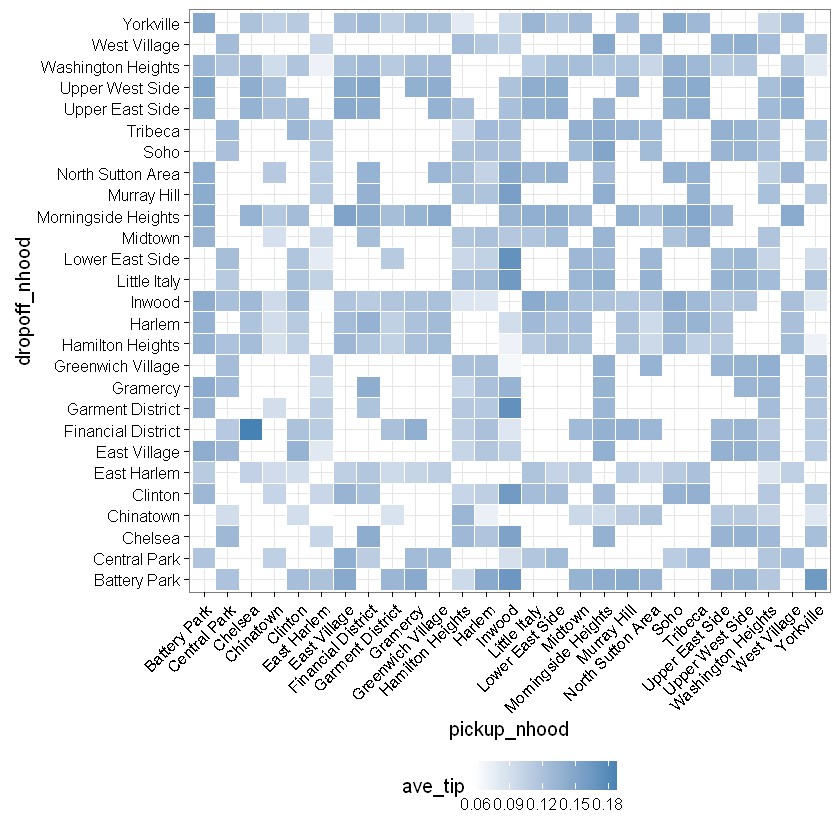

In [49]:
tile_plot_hood(as.data.frame(sum_df))

# Split and Combining Operations with doXdf
## Custom functions across groups
The do verb is an exception to the rule that dplyrXdf verbs write their output as xdf files. This is because do executes arbitrary R code, and can return arbitrary R objects; while a data frame is capable of storing these objects, an xdf file is limited to character and numeric vectors only.

The doXdf verb is similar to do, but where do splits its input into one data frame per group, doXdf splits it into one xdf file per group. This allows do-like functionality with grouped data, where each group can be arbitrarily large. The syntax for the two functions is essentially the same, although the code passed to doXdf must obviously know how to handle xdfs.



In [ ]:
taxi_models <- taxi_xdf %>% group_by(pickup_dow) %>% doXdf(model = rxLinMod(tip_amount ~ fare_amount, data = .))

## Memory Issues
All the caveats that go with working with `data.frames` apply here. While each grouped partition is it's own `RxXdfData` object, the return value must be a `data.frame`, and hence, must fit in memory.
Moreover, the function you apply against the splits will determine how they are operated. If you use an `rx` function, you'll get the nice fault-tolerant, parallel execution strategies the `RevoScaleR` package provides, but for any vanilla/CRAN function will work with data.frames and can easily cause your session to crash.

In [ ]:
library(broom)
taxi_broom <- taxi_xdf %>% group_by(pickup_dow) %>% doXdf(model = glance(lm(tip_amount ~ fare_amount, data = .)))